# Fine-Tuning Meta-Llama-3.1-8B for Machine Translation

This notebook fine-tunes the Meta-Llama-3.1-8B model for Machine Translation using the `wmt/wmt14` dataset. It includes dataset downloading, preprocessing, fine-tuning with LoRA and Unsloth, and evaluation with Accuracy and training loss plotting.

## Setup
- **Environment**: Google Colab with T4 GPU (16GB VRAM).
- **Libraries**: Unsloth for efficient fine-tuning, Hugging Face Transformers, Datasets, and Evaluate for metrics.
- **Dataset**: `wmt/wmt14`.
- **Output**: Fine-tuned model, METEOR, and loss graph.




In [1]:
%%capture
!pip install evaluate
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

## 1. Load Model and tokennizer
Load the Phi-4 model with 4-bit quantization using Unsloth for memory efficiency.

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## 2. Configure Model with QLoRA adapter

Use QLoRA for parameter-efficient fine-tuning.



In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    loftq_config = None,
)

Unsloth 2025.5.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## 3. Load and Preprocess Dataset

We load the `wmt/wmt14` dataset and preprocess it to extract classification tasks.




In [4]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)

from datasets import load_dataset

wmt14_dataset = load_dataset('wmt14', 'fr-en')

def format_IWSLT_for_chat(examples):
    texts = []
    for translation_pair in examples['translation']:
        en_text = translation_pair['en']
        vi_text = translation_pair['fr']

        conversation = [
            {"from": "human", "value": f"Translate this English text to Vietnamese: {en_text}"},
            {"from": "gpt", "value": vi_text}
        ]

        text = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=False)
        texts.append(text)

    return {"text": texts}

total_size = len(wmt14_dataset['train'])
sample_size = int(0.01 * total_size)
subset_dataset = wmt14_dataset['train'].select(range(sample_size))

formatted_dataset = subset_dataset.map(format_IWSLT_for_chat, batched=True)

print("Formatted sample:")
print(formatted_dataset[0]['text'])
print("\n" + "="*50 + "\n")
print(formatted_dataset[1]['text'])

train_size = int(0.9 * len(formatted_dataset))
train_dataset = formatted_dataset.select(range(train_size))
val_dataset = formatted_dataset.select(range(train_size, len(formatted_dataset)))

print(f"\nTotal original dataset size: {total_size}")
print(f"Using 1% subset size: {sample_size}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

Formatted sample:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>human<|end_header_id|>

Translate this English text to Vietnamese: Resumption of the session<|eot_id|><|start_header_id|>gpt<|end_header_id|>

Reprise de la session<|eot_id|>


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>human<|end_header_id|>

Translate this English text to Vietnamese: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.<|eot_id|><|start_header_id|>gpt<|end_header_id|>

Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez p

In [5]:
from evaluate import load
from tqdm import tqdm

meteor = load("meteor")
references_before = []
predictions_before = []

for item in tqdm(val_dataset[:50]["text"]):  # dùng 50 mẫu validation
    # Tách prompt để lấy input tiếng Anh
    input_prompt = item.split("Translate this English text to Vietnamese: ")[1].split("</s>")[0].strip()
    expected_output = item.split("gpt</s>")[-1].strip()

    messages = [{"role": "user", "content": f"Translate this English text to Vietnamese: {input_prompt}"}]
    inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=50,
        use_cache=True,
        temperature=0.1,
        do_sample=False
    )

    prediction = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True).strip()

    predictions_before.append(prediction)
    references_before.append(expected_output)
meteor_score_before = meteor.compute(predictions=predictions_before, references=references_before)
print(f"\nMETEOR score on validation set (before fine-tuning): {meteor_score_before['meteor']:.4f}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  0%|          | 0/50 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
100%|██████████| 50/50 [02:56<00:00,  3.53s/it]



METEOR score on validation set (before fine-tuning): 0.0137


## 4. Setting Up Training Arguments and Fine-tune Model

Use SFTTrainer with Unsloth to fine-tune the model.

In [6]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import os

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        warmup_steps = 2,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = [],
    ),
)

print("Set up trainer successful!")
print(f"training {50} steps with batch size {4}")

Set up trainer successful!
training 50 steps with batch size 4


In [7]:
print("=== START TRAINING ===")
print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: 4")
print(f"Total steps: 50")
print("=" * 50)

trainer_stats = trainer.train()

print("\n=== END TRAINING ===")
print(f"Training loss: {trainer_stats.training_loss:.4f}")
print(f"Total training time: {trainer_stats.metrics.get('train_runtime', 'N/A')} seconds")

=== START TRAINING ===
Dataset size: 367530
Batch size: 4
Total steps: 50


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 367,530 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,4.137100
10,1.964500
15,1.202700
20,1.212400
25,1.137600
30,1.164100
35,0.943700
40,1.066400
45,1.070200
50,1.192900



=== END TRAINING ===
Training loss: 1.5092
Total training time: 169.5518 seconds


## 6. Get Some Examples output

In [8]:
FastLanguageModel.for_inference(model)

test_sentences = [
    "Hello, how are you today?",
    "I love learning new languages.",
    "The weather is beautiful this morning."
]

for sentence in test_sentences:
    messages = [
        {"role": "user", "content": f"Translate this English text to France: {sentence}"}
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt"
    ).to("cuda")

    outputs = model.generate(
        input_ids = inputs,
        max_new_tokens = 50,
        use_cache = True,
        temperature = 0.1,
        do_sample = True
    )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    print(f"English: {sentence}")
    print(f"France translation: {response.strip()}")
    print("-" * 50)

English: Hello, how are you today?
France translation: Bonjour, comment allez-vous aujourd'hui?
--------------------------------------------------
English: I love learning new languages.
France translation: J'adore apprendre de nouvelles langues.
--------------------------------------------------
English: The weather is beautiful this morning.
France translation: Le temps est magnifique ce matin.
--------------------------------------------------


## 7. Evaluate The Model

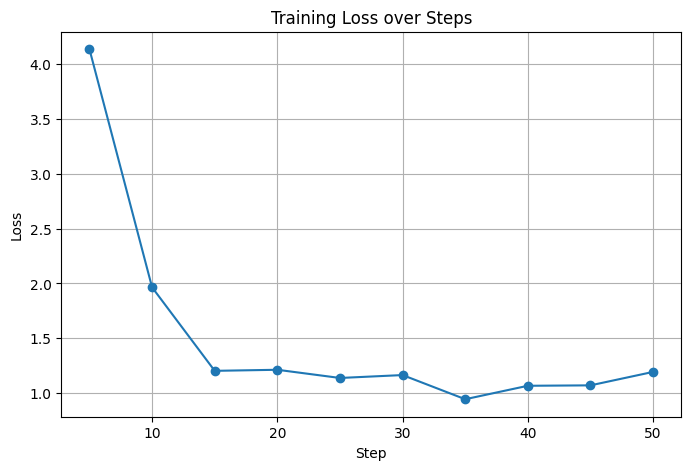

In [9]:
import matplotlib.pyplot as plt

loss_values = trainer.state.log_history

# Trích xuất step và loss
steps = [log['step'] for log in loss_values if 'loss' in log]
losses = [log['loss'] for log in loss_values if 'loss' in log]

# Plot
plt.figure(figsize=(8,5))
plt.plot(steps, losses, marker='o')
plt.title("Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [10]:
from evaluate import load
from tqdm import tqdm

meteor = load("meteor")
references_after = []
predictions_after = []

for item in tqdm(val_dataset[:50]["text"]):  # dùng 50 mẫu validation
    # Tách prompt để lấy input tiếng Anh
    input_prompt = item.split("Translate this English text to Vietnamese: ")[1].split("</s>")[0].strip()
    expected_output = item.split("gpt</s>")[-1].strip()

    messages = [{"role": "user", "content": f"Translate this English text to Vietnamese: {input_prompt}"}]
    inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=50,
        use_cache=True,
        temperature=0.1,
        do_sample=False
    )

    prediction = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True).strip()

    predictions_after.append(prediction)
    references_after.append(expected_output)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 50/50 [02:40<00:00,  3.22s/it]


In [11]:
meteor_score_after = meteor.compute(predictions=predictions_after, references=references_after)
print(f"\nMETEOR score on validation set (after fine-tuning): {meteor_score_after['meteor']:.4f}")


METEOR score on validation set (after fine-tuning): 0.1515


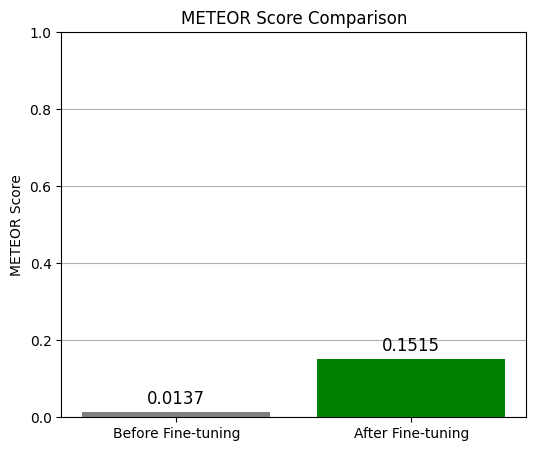

In [14]:
import matplotlib.pyplot as plt

meteor_before = meteor_score_before["meteor"]
meteor_after = meteor_score_after["meteor"]

labels = ["Before Fine-tuning", "After Fine-tuning"]
scores = [meteor_before, meteor_after]

plt.figure(figsize=(6, 5))
plt.bar(labels, scores, color=["gray", "green"])
plt.ylim(0, 1)
plt.title("METEOR Score Comparison")
plt.ylabel("METEOR Score")
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center', fontsize=12)
plt.grid(True, axis="y")
plt.show()


## 8. Login and Save Model to HuggingFace

In [12]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write

In [13]:
model.push_to_hub("thanhle1702/llama3-1-finetuned-wmt14")
tokenizer.push_to_hub("thanhle1702/llama3-1-finetuned-wmt14")

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/thanhle1702/llama3-1-finetuned-wmt14


No files have been modified since last commit. Skipping to prevent empty commit.
